# The Egypt Simulation Model

## An Overview of the Mesa library

Mesa is a Pythonic agent-based modelling framework. It provides for simple, extensible structures to create a simulation model using agents both on and off a spacial plane through inheritance. Mesa also provides an extensible tool to create a visualisation of a model and display graphs of data collected from said model.

This notebook will provide a brief introductory tutorial to Mesa while detailing the setup of the of the model. More details on Mesa and a tutorial on its use can be found here: https://mesa.readthedocs.io/en/master/overview.html

## Creating the model

### Imports
Before we begin creating the model we first need to handle general imports that will be needed for its use. Specific Mesa imports will be handled and explained in the classes in which they are relevant.

In [1]:
import math
import random
from collections import defaultdict

import numpy as np
import pandas

import matplotlib.pyplot as plt
%matplotlib inline

### The Agents
Agents are the basis on which both Mesa and the model operate, using them to interact with model parameters and perform tasks. To create the agents the Mesa "Agent" class structure needs to be imported and implemented to perform the functionality required from the given agent.

In [2]:
from mesa import Agent

#### Tiles
First a basic agent that will be inherited by subsequient agents to represent the map "tiles", which can be Settlements, Rivers or Fields and are defined below, needs to be created.

The Tile has a pos tuple to contain its position on the grid, a boolean to know if the tile is considered settlement territory and a boolean t know if the tile is owned by a Household. Households and Settlements will be expanded on later.

Note that the step function is empty. The step function is called to make an agent do what it needs to do on each model "tick", but as a Tile is just a generic agent that will be extended to be used later, the function is left as a stub for child classes to implement as needed.

In [3]:
class Tile(Agent):
    """
    Class implementing the functionality of an patch in a NetLogo.

    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.
    """

    pos = (0, 0)
    settlementTerritory = False
    owned = False

    def __init__(self, unique_id, model, pos: tuple):
        '''
        Create a new Tile

        Args:
            pos: Tuple representing the position of the agent on a grid
            model: The model in which the agent is being used
        '''
        super().__init__(unique_id, model)
        self.pos = pos

    def step(self):
        pass

#### Rivers
The first type of tile that is implemened will be a River tile. In the current model a river is an area on which Households cannot farm nor claim the land and as such is a stub implementation of the Tile class and does not implement any further on it.

An extension to the model may wish to include ideas such as fishing as a manner in which households can gain food or trade in which boats travelling the river can be used to obtain better profits than land based trading, and as such the River class was created as a stub extensions to use and as an identifier for visualisation purposes.

In [4]:
class River(Tile):
    """
    River agent, currently does nothing and is used only as an identifier
    """

    def __init__(self, unique_id, model, pos: tuple):
        '''
        Create a new River

        Args:
            pos: Tuple representing the position of the agent on a grid
            model: The model in which the agent is being used
        '''
        super().__init__(unique_id, model, pos)

#### Fields
Fields are the second implementation of the Tile class and are one of the main interacting agents in the model. They are farmed by Households so the Households can grow their wealth, and have their fertility values change in a manner such that the annual floods of the Nile are simulated.

Fields fave fertlity values that impact the harvest that can be obtained from them, an average fertility value that can be used in extensions and a number of years that they have lain fallow, which is used to determine if a Household must relinquish its ownership of the Field, and a variable to determine if the Field has been harvested that tick.

The step method updates the fertility values using global parameters obtained from the model and resets the Field to being unharvested through use of the flood method and will be called on each tick.

Extensions to the model may wish to alter the change in fertility values in a manner such that the Fields more closely mirror reality in that repeated crop growth cycles cause the fertility value to decrease, the floods provide a bonus to the Fields fertility and leaving the Field fallow will allow it to recover. To further such an extension livestock grazing could be implemented to help Fields recover faster through manure fertilisation. This type of extension could be used in conjunction with machine learning principles in the Household agents to investigate if Households could learn concepts such as crop rotation, and determine the effects that such would have on the wealth growth of a household.

In [5]:
class Field(Tile):
    """
    Field agent, can be farmed by households and have changing fertility values and owners
    """

    fertility = 0.0
    avf = 0.0
    yearsFallow = 0
    harvested = False

    def __init__(self, unique_id, model, pos: tuple = (0, 0), fertility: float = 0.0):
        '''
        Create a new Field

        Args:
            pos: Tuple representing the position of the agent on a grid
            model: The model in which the agent is being used
            fertility: The starting fertility of the field
        '''
        super().__init__(unique_id, model, pos)
        self.fertility = fertility
        self.avf = fertility
        self.yearsFallow = 0
        self.harvested = False

    def flood(self):
        """
        Changes the fertility value simulating annual flood
        """
        mu = self.model.mu
        # sigma = self.model.sigma
        alpha = self.model.alpha
        beta = self.model.beta
        ticks = self.model.currentTime

        self.fertility = 17 * (beta * (math.exp(0 - (self.pos[0] - mu) ** 2 / alpha)))
        self.avf = ((ticks * self.avf) + self.fertility) / (ticks + 1)
        self.harvested = False

    def step(self):
        self.flood()

#### Settlements

Settlements are largely container elements that exist at a point on the map. Households dwell in Settlements, and this is used to determine what Fields a Household has access to to claim and farm.

Settlments have a population value, which stores the total population of all the Households in the settlement, a number of Households that live in it and a color that is used for visualisation purposes.

The step method performs a check to see if the settlement has gone extinct, and if it has removes it from the model, the map and the scheduler after resetting the area in which it lived to be available for farming.

Extensions to the model might make a settlement tax the Households that dwell in it, in which case migration might be implemented to allow Households would move to a different Settlement if their growth is being restricted by their Settlements taxes, and making extinct Settlements have a time where their territory is "ruined" and unable to be cultivated.

In [6]:
class Settlement(Tile):
    """
    Settlement agent, contains households and has changing population and number of households
    """

    population = 0
    noHouseholds = 0
    color = "#000000"

    def __init__(self, unique_id, model, pos: tuple, population: int, noHouseholds: int, uid, color: str):
        '''
        Create a new Settlement

        Args:
            pos: Tuple representing the position of the agent on a grid
            model: The model in which the agent is being used
            population: The starting population of the setllement (Number of Households * Household Population)
            noHouseholds: The number of Households in the Settlement
        '''
        super().__init__(unique_id, model, pos)
        self.population = population
        self.noHouseholds = noHouseholds
        self.color = color


    def step(self):
        """ Actions to take on a step"""
        # Check if settlement is dead
        if self.population == 0:
            local = self.model.grid.get_neighbors(self.pos, moore=True, include_center=True, radius=1)
            # Mark the land as available for farming. River included for an extension that includes fishing.
            # Can be extended by having a timer where the area is not able to be cultivated.
            for a in local:
                if type(a) is Field or type(a) is River:
                    a.settlementTerritory = False
            # Remove from consideration
            self.model.schedule.remove(self)
            self.model.grid.remove_agent(self)

#### Farm
A Farm stub agent that gets placed on the map to provide a graphical depiction on the visulaisation of if a Household owns a Field, and if they have harvested said Field while still providing a view of the Field's fertility value.

It has a boolean for if it was farmed in the current tick that is modified by the owning Household, and a color to represent the Settlement of the Household that owns it.

Extensions may use this agent to as part of a distinct classification of what Households are doing with their fields, i.e. some Fields are Farms, others are Pastures, Fisheries etc.

In [7]:
class Farm(Tile):
    """Farm stub object for visualsiation purposes"""

    color = ""
    farmed = False

    def __init__(self, unique_id: int, model, pos: tuple, color: str = "#FFFFFF", farmed: bool = False):
        super().__init__(unique_id, model, pos)
        self.color = color
        self.farmed = farmed

#### Households
Households are the primary acting agent in the simulation, and are the target of the simulation's metrics. Households are able to increase and decrease in population, acrue wealth in the form of grain, claim Fields as their own, farm their own Fields and rent unused Fields from other Households. Additionally Households have generations, the generation affecting the ambition and competency values of the Household, which have impact on descision making.

The variables in Household reflect their position, what Settlement they belong to, how much grain they have, how many workers they have, how many workers have worked in the current tick, the ambition and competency values for descision making. Households also have a list of Fields that they own, and a dictionary of Farms, indexed by the position of the corresponding Field for visulisation purposes.

There are many ways in which Households could be extended. Some examples are initially having Households be nomadic hunters and using machine learning to have them possibly learn where a good place to settle and start farming is, or to have Houesholds possibly learn manners in which they can monopolise the economy such as claiming as many fields as possible and charging other Households to rent their land for survival.

In [8]:
class Household(Agent):
    """
    Household agent, the active agent in the simulation, contains information relevant to descision making and metrics
    """

    # Variable declarations for non python programmer sanity
    pos = (0, 0)
    settlement = None
    grain = 0
    workers = 0
    ambition = 0.0
    competency = 0.0
    workersWorked = 0
    generationCountdown = 0
    fields = []
    farms = {} # Dict of farms for visualisation purposes

    def __init__(self, unique_id, model, settlement: Settlement, pos: tuple, grain: int,
                 workers: int, ambition: float, competency: float,
                 generationCountdown: int):
        '''
        Create a new Settlement

        Args:
            pos: Tuple representing the position of the agent on a grid
            settlement: The settlment in which the household resides
            model: The model in which the agent is being used
            grain: The grain that the settlement has
            workers: The number of workers in the Household
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.settlement = settlement
        self.grain = grain
        self.workers = workers
        self.ambition = ambition
        self.competency = competency
        self.generationCountdown = generationCountdown
        self.fields = []
        # For visualisation
        self.farms = {}

    def claimFields(self):
        """
        This method allows households to *decide* whether or not to claim fields that fall within their knowledge-radii.
        The decision to claim is a function the productivity of the field compared to existing fields and ambition.
        """
        chance = np.random.uniform(0, 1)
        if (chance > self.ambition and self.workers > len(self.fields)) or (len(self.fields) <= 1):
            bestFertility = 0
            bestField = None

            # Iterate through fields on the grid
            neighbours = self.model.grid.get_neighbors(pos = self.pos, moore = False, include_center =  False, radius = self.model.knowledgeRadius)
            for a in neighbours:
                if (type(a).__name__ == "Field" and a.fertility > bestFertility 
                        and a.owned == False and a.settlementTerritory == False):
                    bestFertility = a.fertility
                    bestField = a

            # Make claim
            if bestField != None:
                # Redundancy checks
                if (type(bestField).__name__ == "Field" and bestField.owned == False
                        and bestField.settlementTerritory == False):
                    bestField.owned = True
                    bestField.harvested = False
                    bestField.yearsFallow = 0
                    self.fields.append(bestField)

                    # Make farm for visualisation
                    farm = Farm(self.model.next_id(), self.model, bestField.pos, self.settlement.color, False)
                    self.model.grid.place_agent(farm, bestField.pos)
                    self.farms[bestField.pos] = farm

    def farm(self, fields):
        """ Farms fields that the Household owns ifthe chance is met"""
        totalHarvest = 0
        maxYield = 2475
        loops = ((self.workers - self.workersWorked)// 2) # Protection against loop breaking with changes
        
        # Sorting functor
        def fert(field):
            return field.fertility

        fields.sort(key = fert) # Sort fields on fertility so save loop iterations

        for i in range(loops):
            # Optimised looping through fields from NetLogo, saves several loop cycles and calculations 
            for f in fields:
                # If the field is not harvested, setup for harvesting
                if not f.harvested:
                    harvest = (int(f.fertility * maxYield * self.competency) - 
                              (((abs(self.pos[0]) - f.pos[0]) + 
                                 abs(self.pos[1] - f.pos[1])) * 
                                 self.model.distanceCost))
                    # If the chance is met, harvest the field
                    chance = np.random.uniform(0, 1)
                    if (((self.grain > (self.workers * 160)) or (chance < self.ambition * self.competency)) 
                        and (f is not None)):
                        f.harvested = True
                        totalHarvest += harvest - 300  # -300 for planting
                        self.workersWorked += 2
                    break # Stop looping through fields after choosing the best and taking the farm chance
        # Complete farming by updating grain totals
        self.grain += totalHarvest
        self.model.totalGrain += totalHarvest

    def rent(self, fields):
        """
        This method allows more ambition and competent households to farm the unharvested fields owned by other households.
        """
        # Functor to get the ambition of an agent for sorting

        # Checks to see if rental is allowed
        if(self.model.rental == True):
            # Gets a list of the households and sorts by ambition level
            self.farm(fields)   
    
    def consumeGrain(self):
        """
        This method allows households to consume grain based on the number of workers they have.
        Should a household have zero or fewer workers the household will then be removed from the simulation as it has died out.
        The amount of grain consumed is based off of ethnographic data which suggests an adult needs an average of 160kg of grain per year to survive.
        """
        # Consume grain for all workers
        self.model.totalGrain -= self.workers * 160
        self.grain -= self.workers * 160   
        
        # Decrement amount of workers if grain is less than or equal to zero (also impacts overall population numbers)
        if (self.grain <= 0):
            self.model.totalGrain -= self.grain # Add back negative grain to prevent negatve grain in model and incorrect grain representation
            self.grain = 0
            self.workers -= 1
            self.settlement.population -= 1
            self.model.totalPopulation -= 1

            # Check if there are still workers in the Household
            if self.workers <= 0:
                # Removes ownership of all fields
                for f in self.fields:
                    f.owned = False
                # Decrements the amount of households and removes this household from the simulation
                self.settlement.noHouseholds -= 1
                self.model.schedule.remove(self)

    def storageLoss(self):
        """
        This method removes grain from the households total to account for typical annual storage loss of agricultural product
        """
        self.model.totalGrain -= round(self.grain * 0.1) # Prevent grain going to a float because unrestricted types
        self.grain -= round(self.grain*0.1)

    def populationShift(self):
        """
        This method allows for population maintenance as households 'die', simulates movements of workers from failed to more successful households
        """
        startingPopulation = self.model.startingSettlements*self.model.startingHouseholds*self.model.startingHouseholdSize

        populateChance = random.uniform(0,1)

        # If the household can grow, inrease population.
        if (self.model.totalPopulation <= (startingPopulation * ((1 + (self.model.popGrowthRate/100)) ** self.model.currentTime)) 
            and (populateChance > 0.5)):
            self.workers += 1
            self.settlement.population += 1
            self.model.totalPopulation += 1

    def genChangeover(self):
        """
        This method is to simulate what may happen when a relative or child takes over the household and thus allows
        for the level of competency and ambition of a household to change as would be expected when an new person is in control.
        """
        # Decreases the generational countdown 
        self.generationCountdown -= 1

        # Checks if the generation countdown has reached zero and thus will occur
        if self.generationCountdown <= 0:
            # Picks a new random value for the next generation to last (Min of 10 years, Max of 15 years)
            self.generationCountdown = random.randint(0, 5) + 10 

            # continues to recalculate the new ambition value until it is less than one and greater than the model's minimum ambition
            while(True):
                # Chooses an amount to change ambition by between 0 and the generational variance number
                ambitionChange = random.uniform(0, self.model.generationalVariation)
                # Chooses a random number between 0 and 1
                decreaseChance = random.uniform(0,1)

                # If decreaseChance is < 0.5 it causes an ambition decrease for the next generation
                if (decreaseChance < 0.5):
                    ambitionChange *= -1
            
                newAmbition = self.ambition + ambitionChange

                # sets the new ambition and breaks the loop
                if((newAmbition > 1) or (newAmbition < self.model.minAmbition)):
                    self.ambition = newAmbition
                    break

            # continues to recalculate the new competency value until it is less than one and greater than the model's minimum competency
            while(True): 
                # Chooses an amount to change competency by between 0 and the generational variance number
                competencyChange = random.uniform(0, self.model.generationalVariation)
                # Chooses a random number between 0 and 1
                decreaseChance = random.uniform(0,1)

                # If decreaseChance is < 0.5 it causes a competency decrease for the next generation
                if (decreaseChance < 0.5):
                    competencyChange *= -1
            
                newComp = self.competency + competencyChange

                # sets the new competency and breaks the loop
                if(newComp > 1 or newComp < self.model.minCompetency):
                    self.competency = newComp
                    break
           
    def fieldChangeover(self):
        """
        This method checks if an owned field has been harvested or not and tracks how many years it has been unharvested if not.
        Should the field not be harvested for longer than or equal to the fallowlimit then the Household loses ownership
        of the field and it is free for other households to claim.
        """

        # Array to store fields to delete
        toDel = []
        
        # For loop to loop through all owned fields
        for i in range(len(self.fields)):
            # If statement to check if a field has been harvested or not, and set render values for the farms
            if (self.fields[i].harvested == True):
                self.fields[i].yearsFallow = 0
                if self.fields[i].pos in self.farms:
                    self.farms[self.fields[i].pos].farmed = True
            else:
                self.fields[i].yearsFallow += 1
                if self.fields[i].pos in self.farms:
                    self.farms[self.fields[i].pos].farmed = False
            
            # If statement to add fallowlimit exceeding fields to an array of fields to delete
            if (self.fields[i].yearsFallow >= self.model.fallowLimit):
                self.model.grid.remove_agent(self.farms[self.fields[i].pos])# Remove the farm from the map
                del self.farms[self.fields[i].pos] # Remove the farm from list 
                self.fields[i].owned = False
                toDel.append(i - len(toDel)) # Subtract to account for array shrinkage as deletion happens

        # For loop to remove all fallowlimit exceded fields from the Households ownership
        for i in toDel:
            del self.fields[i] # Delete the field

    def fission(self):
        """ Performs household fission if enabled"""
        # If allowed
        if self.model.fission:
            # If chance is met
            if self.model.fissionChance < np.random.uniform(0,1):
                # If requirements are met, create a splinter household
                if self.workers >= 15 and self.grain > (3 * self.workers * (164)):
                    uid = "h" + str(self.model.schedule.get_breed_count(Household) + 1)
                    ambition =  np.random.uniform(self.model.minAmbition, 1)
                    competency = np.random.uniform(self.model.minCompetency, 1)
                    genCount = random.randrange(5) + 10
                    household = Household(uid, self.model, self.settlement, self.pos, 1100, # Grain for 5 workers and 1 field
                                        5, ambition, competency, genCount)
                    self.model.schedule.add(household) # Add to scheduler
                    self.workers -= 5
                    self.grain -= 5

    def step(self):
        """
        The actions to take on a general step sequence
        """
        self.workersWorked = 0
        self.claimFields()
        self.farm(self.fields)
        self.consumeGrain()
        self.storageLoss()
        self.fieldChangeover()
        self.genChangeover()
        self.populationShift()

    def stepFarm(self):
        """
        Calls the farming methods for the initial run of households in the scheduler
        """
        # Reset parameters
        self.workersWorked = 0
        # Farm
        self.claimFields()
        self.farm(self.fields)
    
    def stepRentConsumeChangeover(self, fields):
        """
        Calls the renting, aging, changeover and methods
        """
        self.rent(fields)
        self.consumeGrain()
        self.storageLoss()
        self.fieldChangeover()
        self.genChangeover()
        self.populationShift()
        self.fission()
        # Update grain max for datacollector
        if self.grain > self.model.maxHouseholdGrain:
            self.model.maxHouseholdGrain = self.grain

### The Scheduler
The next required part for the model is a scheduler for the model to use for it to make the agents act in the correct order. This scheduler will be an extension of Mesa's RandomActivation scheduler, but implements activation of agents by a specific "breed" or type.

The sceduler can add agents which will be automatically categorised by breed, and remove agents so they aren't considered anymore.

The step method of the original RandomActivation has been modified to randomly run all of a breed agents, but run through breeds sequentially, or to use it's original functionality and run all agents in a random order.

As Households have behavior that needs to be seperated into seperate steps, when running the Household breed they are seperated into being orderd by wealth then claiming and farming Fields, and being ordered by ambition, renting and performing the changeovers and population growth that are relevant for that tick.

Utility funcitons were added to get the number of agents of a given breed and a list of agents of the breed for use in obtaining metrics and performing operations on agents.

In [9]:
from mesa.time import RandomActivation


class EgyptSchedule(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in a sequence defined by the original NetLogo implementation

    Modifies a default scheduler by calling functions in a specific order "breed" (class) by breed in a random order.

    Does not require a step function due to specificity of ordering for household methods
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule

        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_breed[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_breed[agent_class][agent.unique_id]

    def step(self, by_breed=True):
        """
        Executes the step of each agent breed, one at a time.

        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        """
        if by_breed:
            for agent_class in self.agents_by_breed:
                if agent_class.__name__ == "Household": # Households need seperate treatment for ordering of changeover and rental after farming has occured
                    self.step_households(agent_class)
                else:
                    self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        """
        Shuffle order and run all agents of a given breed.

        Args:
            breed: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_breed[breed].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].step()

    def step_households(self, breed):
        """
        Run all agents of a given household in order of wealth.

        Args:
            breed: Class object of the breed to run.
        """
        # Sorting functors
        def wealth(key):
            return self.agents_by_breed[breed][key].grain

        def ambition(key):
            return self.agents_by_breed[breed][key].ambition

        allFields = [] # List of farms for rental puropses

        agent_keys = list(self.agents_by_breed[breed].keys())
        

        agent_keys.sort(key = wealth) # Sort agents on wealth as in NetLogo ver. Simulates the increased "buying power" of the more wealthy households.
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].stepFarm()
            allFields += self.agents_by_breed[breed][agent_key].fields

        # Sort agents on ambition, rewarding agents for being ambitions if they choose to rent and renting is enabled
        if self.model.rental:
            agent_keys.sort(key = ambition) 

        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].stepRentConsumeChangeover(allFields)

    def get_breed_count(self, breed_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_breed[breed_class].values())

    def get_breed(self, breed):
        """
        Returns all agents of the given breed
        """
        lst = []
        agent_keys = list(self.agents_by_breed[breed].keys())
        for agent_key in agent_keys:
            lst.append(self.agents_by_breed[breed][agent_key])
        return lst

### The Model
The model itself can now be constructed as the prerequisite pieces have been constructed, for ease of reading we will divide the model into two pieces; the functions used in data collection and the model. First the nessecary imports must be handled.

In [10]:
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid

#### Datacollection Methods
The manners in which data can be collected from the model are through a lambda expression in the DataCollector, a custom table to collect data from the model, or through a function that takes the model as a parameter as seen below.

In [11]:
def gini(model):
    """Calculates the Gini-Index of the model"""
    # Sorting functor
    def wealth(agent):
        return agent.grain

    agents = model.schedule.get_breed(Household)
    # print(agent_wealths)
    agents.sort(key = wealth)
    x = []
    for agent in agents:
        x.append(agent.grain)
    N = model.schedule.get_breed_count(Household)
    # Avoid divide by 0 errors
    if N != 0:
        B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
        return round((1 + (1 / N) - 2 * B), 2)
    else:
        return 0

def minSetPop(model):
    """Finds the minimum settlement population in the model"""
    settlements = model.schedule.get_breed(Settlement)
    minPop = float("inf") # Workaround of removal of sys.maxint
    for settlement in settlements:
        if(minPop > settlement.population):
            minPop = settlement.population
    return minPop

def maxSetPop(model):
    """Finds the maximum settlement population in the model"""
    settlements = model.schedule.get_breed(Settlement)
    maxPop = 0
    for settlement in settlements:
        if(maxPop < settlement.population):
            maxPop = settlement.population
    return maxPop

def meanSetPop(model):
    """Finds the mean settlement population in the model"""
    settlements = model.schedule.get_breed(Settlement)
    meanPop = 0
    for settlement in settlements:
        meanPop += settlement.population
    if model.schedule.get_breed_count(Settlement) != 0:
        return round(meanPop/model.schedule.get_breed_count(Settlement), 2)
    else:
        return 0

def minHWealth(model):
    """Finds the minimum household wealth in the model"""
    households = model.schedule.get_breed(Household)
    minWealth = float("inf") # Workaround of removal of sys.maxint
    for household in households:
        if(minWealth > household.grain):
            minWealth = household.grain
    return minWealth

def maxHWealth(model):
    """Finds the maximum household wealth in the model"""
    households = model.schedule.get_breed(Household)
    maxWealth = 0
    for household in households:
        if(maxWealth < household.grain):
            maxWealth = household.grain
    return maxWealth

def meanHWealth(model):
    """Finds the mean household wealth in the model"""
    households = model.schedule.get_breed(Household)
    meanWealth = 0
    for household in households:
        meanWealth += household.grain
    if model.schedule.get_breed_count(Household) != 0:
        return round(meanWealth/model.schedule.get_breed_count(Household), 2)
    else:
        return 0


def lowerThirdGrainHoldings(model):
    """ Determines the number of households that hold below 33% of the highest grain total"""
    households = model.schedule.get_breed(Household)
    count = 0
    for household in households:
        if household.grain <= (model.maxHouseholdGrain / 3):
            count += 1
    return count

def middleThirdGrainHoldings(model):
    """ Determines the number of households that hold between 33% and 66% of the highest grain total"""
    households = model.schedule.get_breed(Household)
    count = 0
    for household in households:
        if ((household.grain > (model.maxHouseholdGrain / 3)) and (household.grain <= ( 2 * model.maxHouseholdGrain / 3))):
            count += 1
    return count

def upperThirdGrainHoldings(model):
    """ Determines the number of households that hold above 66% of the highest grain total"""
    households = model.schedule.get_breed(Household)
    count = 0
    for household in households:
        if household.grain > ( 2 * model.maxHouseholdGrain / 3):
            count += 1
    return count

### The Model Implementation
The model implementation places all the agents on a grid and draws the river on the left side of the grid. The stopping conditions for the model are if an input time span is reached, or if all the Households have died out.

The model contains several variables which will be left to the reader to examine outside of those that cause changes to model function. Fission allows Households to make a splinter Household if their population and amount of grain is large enough, which then creates a new Household within the same Settlement, and rental allows Households to rent unused Fields from each other.

The various setup methods, excluding setupFlood, in the model are used to randomly initialise it with the constructor parameters. 

The DataCollector is instantiated to collect data using the methods above, use lambda expressions to collect various information about the model, and use a table to collect data on the agents. Tables are the best method to collect data on the agents as agent_reporters in the Datacollector are overwritten each tick, unlike model_reporters which hold contiuous reference.

The step method increments the current time, uses setupFlood to update the global variables (mu, sigma, alpha and beta) used by Fields to update their fertility values. It then uses the scheduler to call step on every agent that is in the scheduler, updates the projected historical population and collects the data from that tick. It then checks if the termination methods are met.

In [12]:
class EgyptSim(Model):
    """
    Simulation Model for wealth distribution represented by grain in ancient Egypt
    """

    # Variable declarations for non python programmer sanity
    # Map variables
    height = 30
    width = 30

    # Simulation Variables
    timeSpan = 500
    currentTime = 0
    startingSettlements = 14
    startingHouseholds = 7
    startingHouseholdSize = 5
    startingGrain = 3000
    minAmbition = 0.1
    minCompetency = 0.5
    generationalVariation = 0.9
    knowledgeRadius = 20
    distanceCost = 10
    fallowLimit = 4
    popGrowthRate = 0.1
    fission = False
    fissionChance = 0.7
    rental = True
    rentalRate = 0.5
    totalPopulation = startingSettlements * startingHouseholds * startingHouseholdSize
    totalGrain = startingGrain * startingHouseholds
    startingPopulation = totalPopulation
    projectedHistoricalPopulation = totalPopulation
    maxHouseholdGrain = startingGrain

    # Step variables
    mu = 0
    sigma = 0
    alpha = 0
    beta = 0

    # Visualisation
    description = "A model simulating wealth growth and distribution in Ancient Egypt.\n\nThe model allows one to see how variables such as the flooding of the Nile, human character traits and random chance effect the acquisition and distribution of wealth."

    # List of identifiers and colors for settlements
    SETDICT = {"s1": "#FF0000",
               "s2": "#FF4500",
               "s3": "#BC8F8F",
               "s4": "#00FF00",
               "s5": "#00FFFF",
               "s6": "#0000FF",
               "s7": "#FF00FF",
               "s8": "#FF1493",
               "s9": "#708090",
               "s10": "#DC143C",
               "s11": "#FF8C00",
               "s12": "#FF69B4",
               "s13": "#800000",
               "s14": "#7CFC00",
               "s15": "#008B8B",
               "s16": "#483D8B",
               "s17": "#4B0082",
               "s18": "#FF69B4",
               "s19": "#000000",
               "s20": "#8B4513"}

    def __init__(self, height: int = 30, width: int = 30, timeSpan: int = 500,
                 startingSettlements: int = 14, startingHouseholds: int = 7,
                 startingHouseholdSize: int = 5, startingGrain: int = 3000,
                 minAmbition: float = 0.1, minCompetency: float = 0.5,
                 generationalVariation: float = 0.9, knowledgeRadius: int = 20,
                 distanceCost: int = 10, fallowLimit: int = 4, popGrowthRate: float = 0.1,
                 fission: bool = False, fissionChance: float = 0.7, rental: bool = True,
                 rentalRate: float = 0.5):
        """
        Create a new EgyptSim model
        Args:
            height: The height of the simulation grid
            width: The width of the simulation grid
            timeSpan: The number of years over which the model is to run
            startingSettlements: The starting number of Settlements
            startingHouseholds: The starting number of Households per Settlement
            startingHouseholdSize: The starting number of workers in a Household
            startingGrain: The starting amount of grain for each Household
            minAmbition: The minimum ambition value for a Household
            minCompetency: The minimum competency value for a Household
            generationalVariation: The difference between generations of a Household
            knowledgeRadius: How far outside ther Settlement a Household can "see"
            distanceCost: The cost to move grain per cell away from a settlemnt
            fallowLimit: The number of years a field can lay fallow before it is harvested
            popGrowthRate: The rate at which the population grows
            fission: If Household fission (Moving between settlements) is allowed
            fissionChance: The chance fission occuring
            rental: If land rental is allowed
            rentalRate: The rate at which households will rent land
        """
        super().__init__()
        # Set Parameters
        # Map size
        self.height = height
        self.width = width

        # If the number of starting settlements is greater than the maximum reasonable number of households considering territory and farming area
        # Considers that each household needs at least two field to survive at a minimum number of members, a Settlment needs 9 (territory) + 2 * households
        # Tiles to survive
        if startingSettlements > ((width - 1) * height) // (9 + (startingHouseholds * 2)):
            if startingSettlements > 20:
                self.startingSettlements = 20
            else:
                self.startingSettlements = ((height - 1) * width) // (9 + (startingHouseholds * 2))
            print("Too many starting settlements to support the settlements and household, truncating to: ", self.startingSettlements)
        else:
            self.startingSettlements = startingSettlements
        # Simulation Variables
        self.timeSpan = timeSpan
        self.currentTime = 0
        self.startingHouseholds = startingHouseholds
        self.startingHouseholdSize = startingHouseholdSize
        self.startingGrain = startingGrain
        self.minAmbition = minAmbition
        self.minCompetency = minCompetency
        self.generationalVariation = generationalVariation
        self.knowledgeRadius = knowledgeRadius
        self.distanceCost = distanceCost
        self.fallowLimit = fallowLimit
        self.popGrowthRate = popGrowthRate
        self.fission = fission
        self.fissionChance = fissionChance
        self.rental = rental
        self.rentalRate = rentalRate
        self.totalGrain = startingGrain * startingHouseholds * startingSettlements
        self.totalPopulation = startingSettlements * startingHouseholds * startingHouseholdSize
        self.startingPopulation = self.totalPopulation
        self.projectedHistoricalPopulation = self.startingPopulation
        self.maxHouseholdGrain = startingGrain

        # Scheduler and Grid
        self.schedule = EgyptSchedule(self)
        self.grid = MultiGrid(height = self.height, width = self.width, torus=False)

        # Define specific tables for data collection purposes
        setlist = []
        for i in range(self.startingSettlements):
            setlist.append("s" + str(i + 1) + "_Population")
        tables = {"Settlement Population": setlist}

        # Data collection
        self.datacollector = DataCollector(model_reporters = 
            {"Households": lambda m: m.schedule.get_breed_count(Household),
             "Settlements": lambda m: m.schedule.get_breed_count(Settlement),
             "Total Grain": lambda m: m.totalGrain,
             "Total Population": lambda m: m.totalPopulation,
             "Projected Hisorical Poulation (0.1% Growth)": lambda m: m.projectedHistoricalPopulation,
             "Gini-Index": gini,
             "Maximum Settlement Population": maxSetPop,
             "Minimum Settlement Population": minSetPop,
             "Mean Settlement Poulation" : meanSetPop,
             "Maximum Household Wealth": maxHWealth,
             "Minimum Household Wealth": minHWealth,
             "Mean Household Wealth" : meanHWealth,
             "Number of households with < 33% of wealthiest grain holding": lowerThirdGrainHoldings,
             "Number of households with 33 - 66%  of wealthiest grain holding": middleThirdGrainHoldings,
             "Number of households with > 66% of wealthiest grain holding": upperThirdGrainHoldings 
            },
            tables = tables)

        self.setup()
        self.running = True
        self.collectTableData()
        self.datacollector.collect(self)

    def collectTableData(self):
        setPops = {}
        for s in self.schedule.get_breed(Settlement):
            setPops[s.unique_id + "_Population"] = s.population
        self.datacollector.add_table_row("Settlement Population", setPops, True)

    def setupMapBase(self):
        """
        Create the grid as field and river
        """
        for agent, x, y in self.grid.coord_iter():
            # If on left edge, make a river
            if x == 0:
                uid = "r" + str(x) + "|" + str(y)
                river = River(uid, self, (x, y))
                self.grid.place_agent(river, (x, y))
            # Otherwise make a field
            else:
                uid = "f" + str(x) + "|" + str(y)
                field = Field(uid, self, (x, y), 0.0)
                self.grid.place_agent(field, (x, y))
                self.schedule.add(field)

    def setupSettlementsHouseholds(self):
        """
        Add settlements and households to the simulation
        """
        h = 1
        for i in range(self.startingSettlements):
            # Loop untill a suitable location is found
            while True:
                x = self.random.randrange(1, self.width)
                y = self.random.randrange(self.height)

                flag = False
                cell = self.grid.get_cell_list_contents((x, y))
                # Check that tile is available
                for agent in cell:
                    if agent.settlementTerritory:
                        break
                    else:
                        flag = True
                        break

                if flag:
                    break

            # Add settlement to the grid
            population = self.startingHouseholds * self.startingHouseholdSize
            uid = "s" + str(i + 1) # Use a custom id for the datacollector
            settlement = Settlement(uid, self, (x, y), population, self.startingHouseholds, uid, self.SETDICT[uid])
            self.grid.place_agent(settlement, (x, y))

            # Set the surrounding fields as territory
            local = self.grid.get_neighbors((x, y), moore=True, include_center=True, radius=1)
            for a in local:
                a.settlementTerritory = True

            # Add households for the settlement to the scheduler
            for j in range(self.startingHouseholds):
                huid = "h" + str(h) # Use a custom id for the datacollector
                ambition =  np.random.uniform(self.minAmbition, 1)
                competency = np.random.uniform(self.minCompetency, 1)
                genCount = self.random.randrange(5) + 10
                household = Household(huid, self, settlement, (x, y), self.startingGrain,
                                      self.startingHouseholdSize, ambition, competency, genCount)
                # ! Dont add household to grid, is redundant
                self.schedule.add(household)
                h += 1
            # Add settlement to the scheduler
            self.schedule.add(settlement)

    def setup(self):
        """
        Setup model parameters
        """
        self.setupMapBase()
        self.setupSettlementsHouseholds()

    def step(self):
        self.currentTime += 1
        self.maxHouseholdGrain = 0
        self.setupFlood()
        self.schedule.step()
        self.projectedHistoricalPopulation = round(self.startingPopulation * ((1.001) ** self.currentTime))
        self.datacollector.collect(self)
        # Add settlement data to table 
        self.collectTableData()
        # Cease running once time limit is reached or everyone is dead
        if self.currentTime >= self.timeSpan or self.totalPopulation == 0: 
            self.running = False
 
    def setupFlood(self):
        """
        Sets up common variables used for the flood method in Fields
        """
        self.mu = random.randint(0, 10) + 5
        self.sigma = random.randint(0, 5) + 5
        self.alpha = (2 * self.sigma ** 2)
        self.beta = 1 / (self.sigma * math.sqrt(2 * math.pi))

## Running the Model
The model can easily be run through use of the calling the step method on the model to run a single step, in the case of this model that is one year, or using a while loop that checks the running variable of the model as shown below to run the model from beginning to end, as once the timeSpan has been reached or the total population reaches 0 the model set running to False.

In [13]:
# Create a Model
sim = EgyptSim(height=30, width=30, timeSpan=500, startingSettlements=14, startingHouseholds=7,
                       startingHouseholdSize=5, startingGrain=3000, minAmbition=0.1, minCompetency=0.5,
                       generationalVariation=0.9, knowledgeRadius=20, distanceCost=10, fallowLimit=4,
                       popGrowthRate=0.1, fission=False, fissionChance=0.7, rental=True, rentalRate=0.5)

# Run the model from beginning to end
while(sim.running):
    sim.step()

### Visualisation of the Model
Unfortunately Jupyter Notebooks have no ways of displaying a visualisation of the model as is seen in the main interface, as the visualisation makes use of Chart.js to draw the agents which is currently unsupported. Alternatives such as Holoviews were investigated, however those that could provide a gridded plot can only do so with a single layer and a single agent type.

### Obtaining Data from the Model
To obtain data from the model the data collector can now be used to get the data that is collected each tick. The data in the data collector is stored as a dictionary, but the datacollector will export the data in the form of a Pandas DataFrame as demonstrated below for the model and table data. Note the usage of head() to reduce the number of rows displayed here.

In [14]:
# Obtain model data and display
m_data = sim.datacollector.get_model_vars_dataframe()
m_data.head()

,Households,Settlements,Total Grain,Total Population,Projected Hisorical Poulation (0.1% Growth),Gini-Index,Maximum Settlement Population,Minimum Settlement Population,Mean Settlement Poulation,Maximum Household Wealth,Minimum Household Wealth,Mean Household Wealth,Number of households with < 33% of wealthiest grain holding,Number of households with 33 - 66% of wealthiest grain holding,Number of households with > 66% of wealthiest grain holding
0,98,14,294000,490,490,0.00,35,35,35.00,3000,3000,3000.00,0,0,98
1,98,14,384505,491,490,0.06,36,35,35.07,4739,2985,3923.52,0,3,95
2,98,14,452665,491,491,0.11,36,35,35.07,6220,2648,4619.03,0,28,70
3,98,14,562777,492,491,0.14,36,35,35.14,8630,2668,5742.62,1,52,45
4,98,14,643013,492,492,0.16,36,35,35.14,10320,2252,6561.36,4,54,40


In [15]:
# Obtain table data and display
t_data = sim.datacollector.get_table_dataframe("Settlement Population")
t_data.head()

,s1_Population,s2_Population,s3_Population,s4_Population,s5_Population,s6_Population,s7_Population,s8_Population,s9_Population,s10_Population,s11_Population,s12_Population,s13_Population,s14_Population
0,35,35,35,35,35,35,35,35,35,35,35,35,35,35
1,35,35,35,35,35,35,35,35,35,36,35,35,35,35
2,35,35,35,35,35,35,35,35,35,36,35,35,35,35
3,35,36,35,35,35,35,35,35,35,36,35,35,35,35
4,35,36,35,35,35,35,35,35,35,36,35,35,35,35


### Plotting the Data
Now that the data has been obtained from the data collector, it can be made easier to interpret through use of plots. To do this matplotlib can be used as follows:

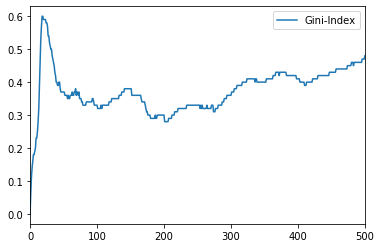

In [16]:
# Plot the Gini-index against time
m_data.plot(kind = "line", y = "Gini-Index")

plt.show()

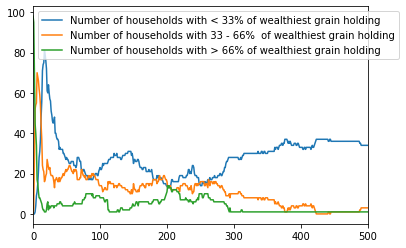

In [17]:
# Plot the grain holding chart
# Use of column numbers rather than column names
m_data.plot(kind = "line", y = [-3, -2, -1])

plt.show()

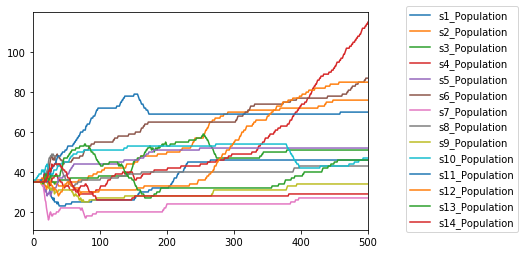

In [18]:
# Display table data on Settlemnt populations
t_data.plot()

# Move legend off to the side
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()